In [27]:
import numpy as np
import pandas as pd
import xarray as xr
import numba as nb

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping, StochasticWeightAveraging
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import make_scorer, log_loss
from sklearn.utils import shuffle


from xgboost import XGBClassifier

from glob import glob
from tqdm import tqdm
import itertools 
import time

from typing import Optional, List, Union
import logging
from IPython.utils import io

import spect

In [18]:
import imp
imp.reload(spect)

<module 'spect' from '/exports/csce/datastore/geos/users/s1205782/Projects/spect/notebooks/spect.py'>

# **Load and proprocess data**

In [3]:
bins = np.arange(0, 1350, 50)
ds_bin = spect.get_binned_data(bins=bins)

100%|███████████████████████████████████████████████████████████████████████████████| 1570/1570 [04:19<00:00,  6.06it/s]


In [4]:
ds_bin

<xarray.Dataset>
Dimensions:          (sample_id: 1570, mz: 101, temp_bins: 26, species: 10)
Coordinates:
  * sample_id        (sample_id) object 'S0000' 'S0001' ... 'S1568' 'S1569'
  * mz               (mz) int64 0 1 2 3 4 5 6 7 8 ... 93 94 95 96 97 98 99 100
  * temp_bins        (temp_bins) object (0, 50] (50, 100] ... (1250, 1300]
  * species          (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'
Data variables:
    abundance        (sample_id, temp_bins, mz) float64 5.543e-11 ... nan
    time             (sample_id, temp_bins) float64 61.56 266.8 ... nan nan
    temp             (sample_id, temp_bins) float64 40.9 74.9 122.9 ... nan nan
    labels           (sample_id, species) float64 0.0 0.0 0.0 ... nan nan nan
    split            (sample_id) object 'train' 'train' ... 'test' 'test'
    instrument_type  (sample_id) object 'commercial' ... 'sam_testbed'

In [5]:
ds_scale = ds_bin['abundance'].mean(dim=('temp_bins', 'mz')).groupby(ds_bin.instrument_type).mean()
missing_fill = np.nan

def preprocess(ds, drop_he=False, rebase=False, maxscale=True, scale_int=True, log_scale=False):
    ds_pro = ds
    ds_pro['integrated_abundance'] = ds_pro['abundance'].mean(dim='temp_bins')
    if scale_int:
        ds_pro['integrated_abundance'] = (
            (ds_pro['integrated_abundance'].groupby(ds.instrument_type)/ds_scale)
            .drop('instrument_type')
        )
    ds_pro['features'] = ds_pro['abundance']
    if rebase:
        ds_pro['features'] = ds_pro.features - ds_pro.features.min(dim=('temp_bins'))
    if drop_he:
        ds_pro = ds_pro.drop_sel(mz=4)
    if maxscale:
        ds_pro['features'] = ds_pro.features/ds_pro.features.max(dim=('temp_bins', 'mz'))
    if log_scale:
        ds_pro['features'] = np.log10(ds_pro['features'].clip(1e-4,None))
        ds_pro['integrated_abundance'] = np.log10(ds_pro['integrated_abundance'].clip(1e-4,None))
    ds_pro = ds_pro.fillna(missing_fill)
    return ds_pro

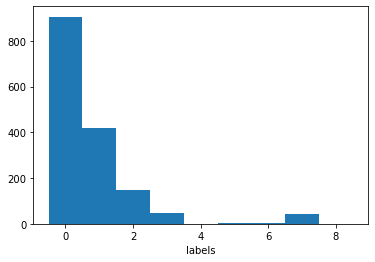

In [6]:
clip_n=9
ds_bin.labels.sum(dim='species').clip(0, clip_n).plot.hist(bins = np.arange(0,clip_n+1)-.5)
plt.show()

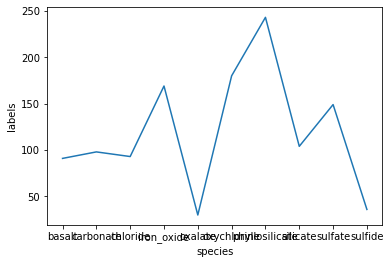

In [7]:
ds_bin.labels.sum(dim='sample_id').plot()

In [8]:
species_positive = ds_bin.where(
    (ds_bin.labels.sel(species='carbonate'))==1, #+
    #ds_bin.labels.sum(dim='species')>0)==2,
    drop=True)

In [9]:
species_positive

<xarray.Dataset>
Dimensions:          (sample_id: 98, temp_bins: 26, mz: 101, species: 10)
Coordinates:
  * sample_id        (sample_id) object 'S0001' 'S0003' ... 'S0747' 'S0755'
  * mz               (mz) int64 0 1 2 3 4 5 6 7 8 ... 93 94 95 96 97 98 99 100
  * temp_bins        (temp_bins) object (0, 50] (50, 100] ... (1250, 1300]
  * species          (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'
Data variables:
    abundance        (sample_id, temp_bins, mz) float64 nan 5.377e-10 ... nan
    time             (sample_id, temp_bins) float64 845.7 993.1 ... nan nan
    temp             (sample_id, temp_bins) float64 24.5 73.93 125.6 ... nan nan
    labels           (sample_id, species) float64 0.0 1.0 0.0 ... 0.0 1.0 0.0
    split            (sample_id) object 'train' 'train' ... 'train' 'train'
    instrument_type  (sample_id) object 'commercial' ... 'sam_testbed'

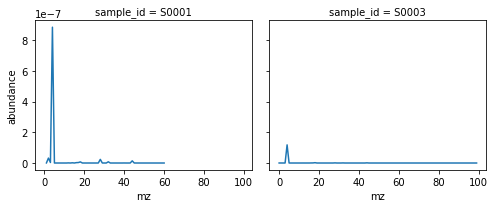

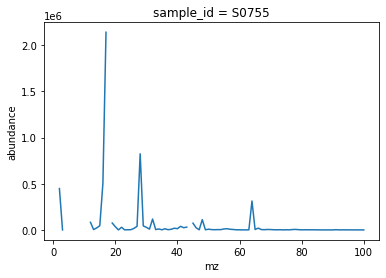

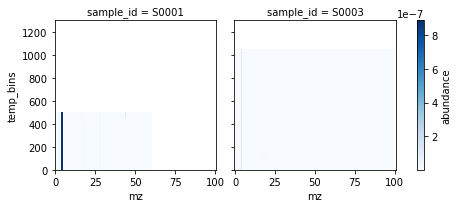

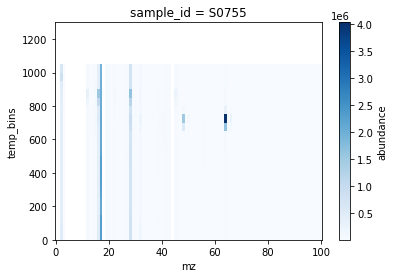

In [10]:
import matplotlib.colors as colors
norm=colors.LogNorm(vmin=0)

n=2
#norm=colors.Normalize(vmin=.01, vmax=1)
for s in np.unique(ds_bin.instrument_type):
    x = species_positive.abundance\
            .where(ds_bin.instrument_type==s, drop=True) \
            .isel(sample_id=slice(0,n)) \
            .mean(dim='temp_bins')
    if len(x.sample_id)==0:
        continue
    elif len(x.sample_id)==1:
        x.plot()
    else:
        x.plot(col="sample_id")#, col_wrap=4)#, norm=norm, cmap='Blues')            
    plt.show()

for s in np.unique(ds_bin.instrument_type):
    x = species_positive.abundance\
        .where(ds_bin.instrument_type==s, drop=True) \
        .isel(sample_id=slice(0,n))
    
    if len(x.sample_id)==0:
        continue
    elif len(x.sample_id)==1:
        x.plot(cmap='Blues')
    else:
        x.plot(col="sample_id",cmap='Blues')#, col_wrap=4)#, norm=norm, cmap='Blues')            
    plt.show()


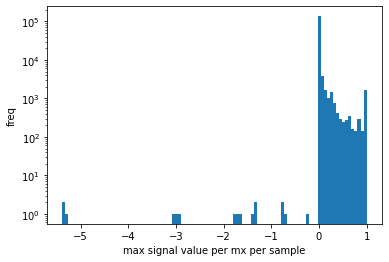

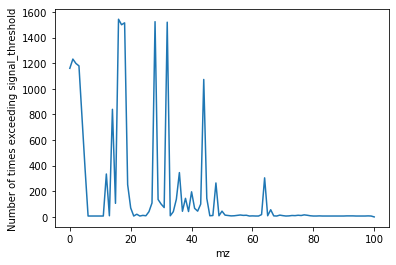

Number of mz with signal_threshold=0.01 and occurence_threshold=1 is : 99


In [11]:
ds = preprocess(ds_bin, drop_he=True)


(ds.features.max(dim=('temp_bins'))).plot.hist(bins=100);
plt.yscale('log')
plt.xlabel('max signal value per mx per sample')
plt.ylabel('freq')
plt.show()

signal_threshold = 0.01 # 0.01 used for sub
occurence_threshold = 1 # 10 used for sub

x = (ds.features.max(dim=('temp_bins'))>signal_threshold).sum(dim='sample_id')
x.plot()
plt.xlabel('mz')
plt.ylabel(f'Number of times exceeding signal_threshold')
plt.show()
print(f"Number of mz with signal_threshold={signal_threshold} and occurence_threshold={occurence_threshold} is : {(x>occurence_threshold).sum().item()}")

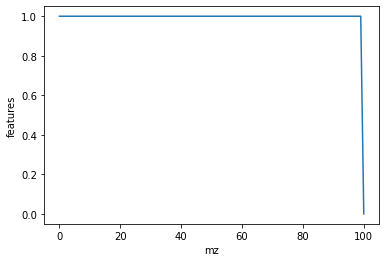

In [12]:
## get rid of mz which don't have strong signal many times
mz_mask = (ds.features.max(dim=('temp_bins'))>signal_threshold).sum(dim='sample_id') > occurence_threshold
mz_mask = mz_mask.reindex(mz=ds_bin.mz).fillna(True)
mz_mask.plot()

In [13]:
ds_bin_filt = ds_bin.sel(mz=mz_mask.astype(bool))
ds_bin_filt

<xarray.Dataset>
Dimensions:               (sample_id: 1570, mz: 100, temp_bins: 26, species: 10)
Coordinates:
  * sample_id             (sample_id) object 'S0000' 'S0001' ... 'S1568' 'S1569'
  * mz                    (mz) int64 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99
  * temp_bins             (temp_bins) object (0, 50] (50, 100] ... (1250, 1300]
  * species               (species) <U14 'basalt' 'carbonate' ... 'sulfide'
Data variables:
    abundance             (sample_id, temp_bins, mz) float64 5.543e-11 ... nan
    time                  (sample_id, temp_bins) float64 61.56 266.8 ... nan nan
    temp                  (sample_id, temp_bins) float64 40.9 74.9 ... nan nan
    labels                (sample_id, species) float64 0.0 0.0 0.0 ... nan nan
    split                 (sample_id) object 'train' 'train' ... 'test' 'test'
    instrument_type       (sample_id) object 'commercial' ... 'sam_testbed'
    integrated_abundance  (sample_id, mz) float64 0.02868 0.02717 ... nan nan
    features              (sample_id, temp_bins, mz) float64 5.543e-11 ... nan

## Process data

In [14]:
from skmultilearn.model_selection import iterative_train_test_split


def base2_split(indices, y, splits):
    log2_splits = np.log2(splits)
    assert log2_splits==int(log2_splits)
    if log2_splits==1:
        indices_1, _, indices_2, _ = iterative_train_test_split(indices, y, test_size=0.5)
        return [indices_1, indices_2]
    else:
        indices_1, y_1, indices_2, y_2 = iterative_train_test_split(indices, y, test_size=0.5)
        return base2_split(indices_1, y_1, splits//2)+base2_split(indices_2, y_2, splits//2)

def cross_val_splits(ds, splits, random_seed=None):
    np.random.seed(random_seed)
    y = ds.labels.values
    indices = shuffle(ds.sample_id.values[:,None])
    partitions = base2_split(indices, y, splits=splits)
    ds_train_test = []
    for p in partitions:
        ds_train_test.append((ds.drop_sel(sample_id=p[:,0]), ds.sel(sample_id=p[:,0])))
    return ds_train_test

def cross_val_splitsog(ds, splits, random_seed=None):
    shuffled_ids = shuffle(ds.sample_id.values, random_state=random_seed)
    n = len(shuffled_ids)//splits
    partitions = [shuffled_ids[i*n:(i+1)*n] for i in range(splits)]
    ds_train_test = []
    for p in partitions:
        ds_train_test.append((ds.drop_sel(sample_id=p), ds.sel(sample_id=p)))
    return ds_train_test

In [15]:
def augment_ds(ds, factor=1, random_state=None):
    ids1 = ds.where(ds.instrument_type=='commercial', drop=True).sample_id.values
    ids2 = ds.where(ds.instrument_type=='sam_testbed', drop=True).sample_id.values
    pairs = shuffle(
        list(itertools.product(ids1, ids1)), 
        random_state=random_state, 
        n_samples=int(len(ids1)*factor)
    )
    if len(ids2)>=2:
        pairs += shuffle(
            list(itertools.product(ids2, ids2)), 
            random_state=random_state, 
            n_samples=int(len(ids2)*factor)
        )
    ds_1 = ds.sel(sample_id=[s[0] for s in pairs])
    ds_2 = ds.sel(sample_id=[s[1] for s in pairs])
    new_sample_ids = ['+'.join(s) for s in pairs]
    ds_1['sample_id'] = new_sample_ids
    ds_2['sample_id'] = new_sample_ids
    
    ds_aug = ds_1+ds_2
    
    ds_aug['split'] = ds_1['split']
    ds_aug['instrument_type'] = ds_1['instrument_type']
    ds_aug['temp'] = ds_1['temp']
    ds_aug['time'] = ds_aug['time'] / 2
    ds_aug['labels'] = ds_1['labels'].clip(0,1)
    ds_aug['abundance'] = ds_aug['abundance'] / 2
    return xr.merge([ds, ds_aug])

### Final dataset

In [16]:
ds_final = ds_bin_filt.where(ds_bin.split=='train', drop=True)

ds_final

<xarray.Dataset>
Dimensions:               (sample_id: 766, temp_bins: 26, mz: 100, species: 10)
Coordinates:
  * sample_id             (sample_id) object 'S0000' 'S0001' ... 'S0764' 'S0765'
  * mz                    (mz) int64 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99
  * temp_bins             (temp_bins) object (0, 50] (50, 100] ... (1250, 1300]
  * species               (species) <U14 'basalt' 'carbonate' ... 'sulfide'
Data variables:
    abundance             (sample_id, temp_bins, mz) float64 5.543e-11 ... nan
    time                  (sample_id, temp_bins) float64 61.56 266.8 ... nan nan
    temp                  (sample_id, temp_bins) float64 40.9 74.9 ... nan nan
    labels                (sample_id, species) float64 0.0 0.0 0.0 ... 0.0 0.0
    split                 (sample_id) object 'train' 'train' ... 'train' 'train'
    instrument_type       (sample_id) object 'commercial' ... 'sam_testbed'
    integrated_abundance  (sample_id, mz) float64 0.02868 0.02717 ... 0.0006179
    features              (sample_id, temp_bins, mz) float64 5.543e-11 ... nan

In [17]:
def this_preprocess(ds):
    return preprocess(ds, drop_he=False, rebase=False, maxscale=True, scale_int=True, log_scale=False)

# **xgboost**

## Functions

In [19]:
def mean_and_uncert(random_search):
    i = np.argwhere(random_search.cv_results_["mean_test_score"]==random_search.best_score_).item()
    m = random_search.cv_results_["mean_test_score"][i]
    s = random_search.cv_results_["std_test_score"][i]
    return m,s

def compile_best_score(random_search):
    m,s = mean_and_uncert(random_search)
    return string_uncert(m,s)

def string_uncert(m,s):
    return f"{m:.3f} +- {s:.3f}"

scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

In [58]:
params_master = {
    'min_child_weight': [.05,.1,.5,1,2,4,8],
    'gamma': [0., 0.001, 0.01, 0.05, 0.1, 0.5, 1, 2],
    'subsample': [0.6, 0.8, 0.9, 0.95],
    #'colsample_bylevel': [0.8, 0.9, 0.95],
    'colsample_bytree': [0.6, 0.8, 0.9, 0.95],
    'reg_alpha': [0, .01, .1, .2],
    'max_depth' : [3, 4, 5, 6, 7, 8],
    'learning_rate' : [.01, .02, .05,],
    'n_estimators' : [500],
    'max_delta_step': [1, 5, None],
    'scale_pos_weight':[1, 2, 4, 8],
}

first_level_model_params = dict(
    min_child_weight=1,
    gamma=.5,
    subsample=0.9,
    colsample_bytree=0.8,
    max_depth=4,
    learning_rate=0.1,
    n_estimators=100,
)

test_n_params = 20
early_stopping_rounds = 5

from sklearn.model_selection import ParameterSampler
import sklearn
import dask

scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

class RandomCVDummy:
    def __init__(self):
        self.best_estimator_ = None
        self.best_score_ = -np.inf
        self.all_scores = []
        self.all_estimators = []
        
    def update(self, model, score):
        self.all_scores += [score]
        self.all_estimators += [model]
        if score > self.best_score_:
            self.best_score_ = score
            self.best_estimator_ = model

@dask.delayed
def fit_and_score(clf, X_train, y_train,  X_val, y_val):
    clf.fit(
        X_train, y_train, 
        eval_set=((X_train, y_train), (X_val, y_val),), 
        early_stopping_rounds=early_stopping_rounds, 
        eval_metric="logloss",
        verbose=0
    )
    s = scorer(clf, X_val, y_val)
    return clf, s
    
            
def multi_random_search(clf, X_train, y_train, X_val, y_val, params, labels=None):
    if labels is None:
        lables = np.arange(y_train.shape[1])
    
    random_search_individual = {}
    for label, col in tqdm(zip(labels, range(y_train.shape[1]))):
        y_col = y_train[:, col]
        
        param_sam = ParameterSampler(params, n_iter=test_n_params, random_state=1001)
        
        random_search_individual[label] = RandomCVDummy()
        
        fits = []
        for ps in param_sam:
            this_clf = sklearn.base.clone(clf).set_params(**ps)
            fits.append(fit_and_score(this_clf, X_train, y_col, X_val, y_val[:, col]))
        for this_clf, s in dask.compute(*fits, scheduler='threads'):
            random_search_individual[label].update(this_clf, s)
    
    return random_search_individual


def simple_first_layer_model(clf, X_train, y_train, X_val, y_val, params, labels=None):
    if labels is None:
        lables = np.arange(y_train.shape[1])
    
    random_search_individual = {}
    for label, col in tqdm(zip(labels, range(y_train.shape[1]))):
        y_col = y_train[:, col]
        
        param_sam = ParameterSampler(params, n_iter=test_n_params, random_state=1001)
        
        random_search_individual[label] = RandomCVDummy()
        
        fits = []
        for ps in param_sam:
            this_clf = sklearn.base.clone(clf).set_params(**ps)
            fits.append(fit_and_score(this_clf, X_train, y_col, X_val, y_val[:, col]))
        for this_clf, s in dask.compute(*fits, scheduler='threads'):
            random_search_individual[label].update(this_clf, s)
    
    return random_search_individual


def prepare_data_xg(ds, extra_x=None):
    
    X = [
        ds.features.stack(dict(z=("temp_bins","mz"))).values, 
        (ds.instrument_type.values=='commercial').astype(float)[:, None],
        ds.integrated_abundance.values,
        ds.time.values,
    ]
    if extra_x is not None:
        X += extra_x
    
    X = np.concatenate(X, axis=1)

    y = ds.labels.values
    return X, y

def train_xgboost(ds_train, ds_val, random_state=None, stacked=False):
    
    X_train, y_train = prepare_data_xg(ds_train)
    X_val, y_val = prepare_data_xg(ds_val)
    
    if stacked:
        first_clf = MultiOutputClassifier(
            XGBClassifier(
                n_jobs=20,
                eval_metric='logloss',
                gpu_id=0,
                use_label_encoder=False,
                missing=missing_fill,
                tree_method='exact',
                **first_level_model_params,
            )
        )
        first_clf.fit(X_train, y_train)
        extra_x_train = [np.array(first_clf.predict_proba(X_train))[...,1].T]
        X_train, y_train = prepare_data_xg(ds_train, extra_x=extra_x_train)
        
        extra_x_val = [np.array(first_clf.predict_proba(X_val))[...,1].T]
        X_val, y_val = prepare_data_xg(ds_val, extra_x=extra_x_val)
        
    params = params_master

    clf = XGBClassifier(
            n_jobs=20,
            eval_metric='logloss',
            gpu_id=0,
            use_label_encoder=False,
            missing=missing_fill,
            tree_method='exact'
    )

    random_search_results = multi_random_search(clf, X_train, y_train, X_val, y_val, params, labels=ds_train.species.values)
    if stacked:
        random_search_results['first_level_model'] = first_clf
    return random_search_results

def predict_with_xgboost_model(search_results, ds):
    X, _ = prepare_data_xg(ds)
    
    first_clf = search_results.get('first_level_model', None)
    if first_clf is not None:
        extra_x = [np.array(first_clf.predict_proba(X))[...,1].T]
        X, _ = prepare_data_xg(ds, extra_x=extra_x)
    
    y_preds = []
    for species in ds.species.values:
        model = search_results[species].best_estimator_
        y_preds += [model.predict_proba(X)[:,1:]]
    y_preds = np.concatenate(y_preds, axis=1)
    name = 'xg_preds'
    ds[name] = xr.DataArray(
        y_preds, 
        dims=['sample_id', 'species'], 
        coords=[ds.sample_id.values, ds.species.values], 
        name=name
    )
    return ds
        

In [59]:
def log_loss_per_species(yt, yp):
    return -(yt*np.log(yp)+(1-yt)*np.log(1-yp)).mean(dim=('sample_id'))

In [60]:
def tprint(m):
    print(f"{time.asctime()} - {m}")

In [61]:
def cross_val(ds_train, ds_val, random_state=None):
    
    ds_train = augment_ds(ds_train, factor=1, random_state=random_state)
    ds_train = this_preprocess(ds_train)
    ds_val = this_preprocess(ds_val)
    
    tprint("Training xgboost")
    xg_random_search_results = train_xgboost(ds_train, ds_val, stacked=True, random_state=None)
    
    ds_train = predict_with_xgboost_model(xg_random_search_results, ds_train)
    ds_val = predict_with_xgboost_model(xg_random_search_results, ds_val)
    
    losses = xr.merge([
        log_loss_per_species(ds_train.labels, ds_train.xg_preds).to_dataset(name='xg_train_loss'),
        log_loss_per_species(ds_val.labels, ds_val.xg_preds).to_dataset(name='xg_val_loss'),
    ])
    
    results = dict(
        xg_results=xg_random_search_results,
        losses=losses,
    )
    return results

## Run

In [62]:
ds_train_test_splits = cross_val_splits(ds_final, 8, random_seed=317984)

In [63]:
cross_val_results = []
for i, split in enumerate(ds_train_test_splits):
    tprint(f'Split {i+1} of {len(ds_train_test_splits)}')
    cross_val_results.append(cross_val(*split, random_state=98787+i))

Mon Mar 14 17:56:23 2022 - Split 1 of 8
Mon Mar 14 17:56:23 2022 - Training xgboost


10it [04:03, 24.31s/it]


Mon Mar 14 18:00:50 2022 - Split 2 of 8
Mon Mar 14 18:00:51 2022 - Training xgboost


10it [03:49, 22.98s/it]


Mon Mar 14 18:05:04 2022 - Split 3 of 8
Mon Mar 14 18:05:04 2022 - Training xgboost


10it [04:20, 26.01s/it]


Mon Mar 14 18:09:47 2022 - Split 4 of 8
Mon Mar 14 18:09:47 2022 - Training xgboost


10it [03:17, 19.71s/it]


Mon Mar 14 18:13:27 2022 - Split 5 of 8
Mon Mar 14 18:13:27 2022 - Training xgboost


10it [04:24, 26.49s/it]


Mon Mar 14 18:18:14 2022 - Split 6 of 8
Mon Mar 14 18:18:15 2022 - Training xgboost


10it [04:10, 25.04s/it]


Mon Mar 14 18:22:49 2022 - Split 7 of 8
Mon Mar 14 18:22:49 2022 - Training xgboost


10it [03:53, 23.39s/it]


Mon Mar 14 18:27:06 2022 - Split 8 of 8
Mon Mar 14 18:27:07 2022 - Training xgboost


10it [03:47, 22.74s/it]


## Losses

In [64]:
losses = xr.merge([l['losses'].expand_dims(dim='split', axis=1).assign_coords(split=[i]) for i, l in enumerate(cross_val_results)])
losses.mean(dim=('split', 'species'))

<xarray.Dataset>
Dimensions:        ()
Data variables:
    xg_train_loss  float64 0.05259
    xg_val_loss    float64 0.1788

In [65]:
losses.mean(dim='split')

<xarray.Dataset>
Dimensions:        (species: 10)
Coordinates:
  * species        (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'
Data variables:
    xg_train_loss  (species) float64 0.05632 0.04211 0.04752 ... 0.07509 0.01389
    xg_val_loss    (species) float64 0.1973 0.1587 0.1764 ... 0.2363 0.07336

In [66]:
losses

<xarray.Dataset>
Dimensions:        (split: 8, species: 10)
Coordinates:
  * split          (split) int64 0 1 2 3 4 5 6 7
  * species        (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'
Data variables:
    xg_train_loss  (species, split) float64 0.04347 0.07648 ... 0.006276 0.01748
    xg_val_loss    (species, split) float64 0.1783 0.2689 ... 0.0175 0.1083

In [67]:
len(cross_val_results)

8

In [68]:
def f(results, ds):
    ds = this_preprocess(ds)
    xg_results = results['xg_results']

    ds = predict_with_xgboost_model(xg_results, ds)
    return ds.rename({'xg_preds':'preds'})[['preds', 'labels']]

In [69]:
preds_list = [f(cv_result, ds_val) for cv_result, (_, ds_val) in zip(cross_val_results, ds_train_test_splits)]

In [70]:
preds_list[0]

<xarray.Dataset>
Dimensions:    (sample_id: 96, species: 10)
Coordinates:
  * sample_id  (sample_id) object 'S0344' 'S0622' 'S0759' ... 'S0160' 'S0069'
  * species    (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'
Data variables:
    preds      (sample_id, species) float32 0.04299 0.05596 ... 0.04068 0.003493
    labels     (sample_id, species) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


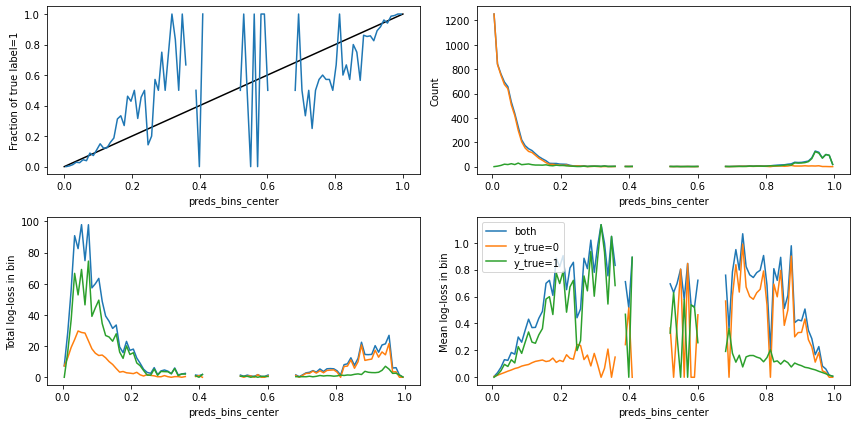

In [71]:
def all_log_loss(yt, yp):
    return -(yt*np.log(yp)+(1-yt)*np.log(1-yp))

fig, axes = plt.subplots(2,2, figsize=(12,6))
ds = xr.merge(preds_list)
ax = axes[0, 0]
ax.plot([0,1], [0,1], color='k')
ds.groupby_bins(ds.preds, np.linspace(0,1,100)).mean().labels.plot(ax=ax)
ax.set_ylabel('Fraction of true label=1')

ax = axes[0, 1]
ds.groupby_bins(ds.preds, np.linspace(0,1,100)).count().labels.plot(ax=ax, label='both')
ds.where(ds.labels==0).groupby_bins(ds.preds, np.linspace(0,1,100)).count().labels.plot(ax=ax, label='y_true=0')
ds.where(ds.labels==1).groupby_bins(ds.preds, np.linspace(0,1,100)).count().labels.plot(ax=ax, label='y_true=0')
ax.set_ylabel('Count')

ax = axes[1, 0]
x = all_log_loss(ds.labels, ds.preds.clip(0.0, None))
x.groupby_bins(ds.preds, np.linspace(0,1,100)).sum().plot(ax=ax, label='both')
x.where(ds.labels==0).groupby_bins(ds.preds, np.linspace(0,1,100)).sum().plot(ax=ax, label='y_true=0')
x.where(ds.labels==1).groupby_bins(ds.preds, np.linspace(0,1,100)).sum().plot(ax=ax, label='y_true=1')
ax.set_ylabel('Total log-loss in bin')
plt.legend()

ax = axes[1, 1]
x.groupby_bins(ds.preds, np.linspace(0,1,100)).mean().plot(ax=ax, label='both')
x.where(ds.labels==0).fillna(0).groupby_bins(ds.preds, np.linspace(0,1,100)).mean().plot(ax=ax, label='y_true=0')
x.where(ds.labels==1).fillna(0).groupby_bins(ds.preds, np.linspace(0,1,100)).mean().plot(ax=ax, label='y_true=1')
ax.set_ylabel('Mean log-loss in bin')
plt.legend()

plt.tight_layout()
plt.show()

Most error comes from false negatives

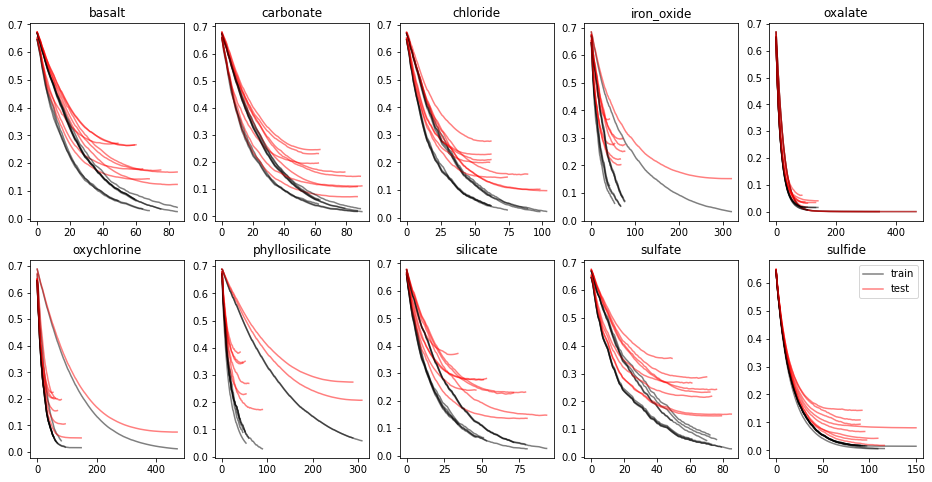

In [72]:
def plot_learning_curve(model, ax=None, add_label=False):
    if ax is None:
        ax = plt.subplot(111)
    results = model.evals_result()
    ax.plot(results['validation_0']['logloss'], label='train' if add_label else None, color='k', alpha=.5)
    ax.plot(results['validation_1']['logloss'], label='test' if add_label else None, color='r', alpha=.5)
    return ax

fig, axes = plt.subplots(2, 5, figsize=(16,8))
for ax, species in zip(axes.flatten(), ds_final.species.values):
    for i, cv in enumerate(cross_val_results):
        plot_learning_curve(cv['xg_results'][species].best_estimator_, ax=ax, add_label=i==0)
    ax.set_title(species)
ax.legend()
plt.show()

10 plots


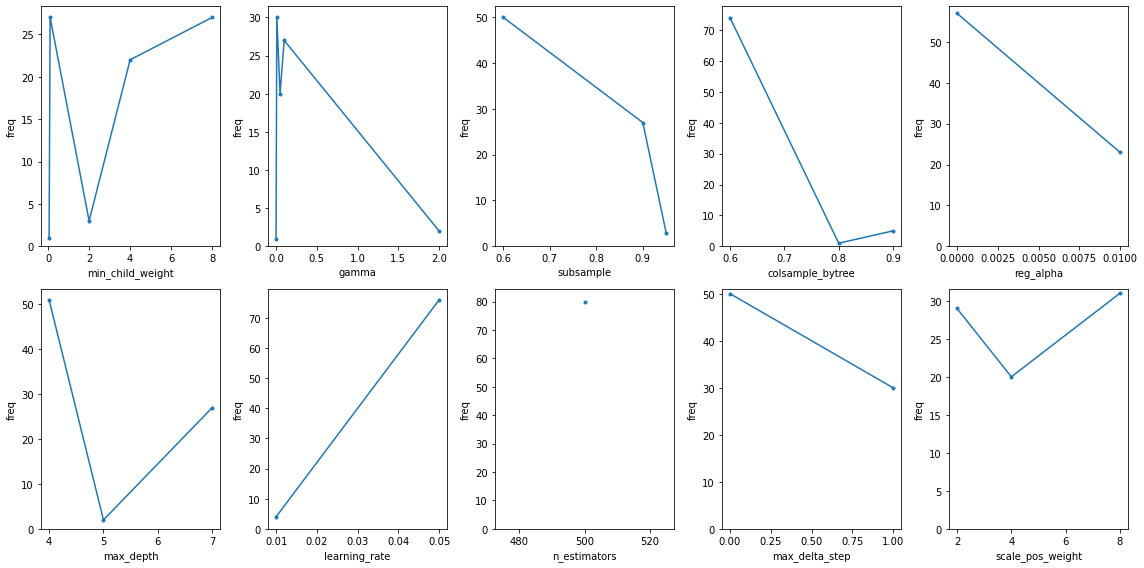

In [73]:
n = len(params_master.keys())
print(f"{n} plots")
fig, axes = plt.subplots(2, n//2, figsize=(16,8))

for ax, k in zip(axes.flatten(), params_master.keys()):
    x = [cv['xg_results'][species].best_estimator_.get_params()[k] for cv in cross_val_results for species in ds_final.species.values]
    x = np.unique(x, return_counts=True)
    ax.plot(*x, marker='.')
    ax.set_xlabel(k)
    ax.set_ylim(0, None)
    ax.set_ylabel('freq')
    plt.tight_layout()
plt.show()

# **Prepare submission**

In [511]:
def predict_from_cross_val_result(results, ds):
    
    xg_results = results['xg_results']

    ds = predict_with_xgboost_model(xg_results, ds)
    return ds.rename({'xg_preds':'preds'}).preds

In [512]:
ds_sub = ds_bin_filt.where(ds_bin_filt.split!='train', drop=True)
ds_sub = this_preprocess(ds_sub)

In [513]:
preds_list = [predict_from_cross_val_result(cv_result, ds_sub) for cv_result in cross_val_results]

In [514]:
preds = xr.merge([pred.expand_dims(dim='split', axis=1).assign_coords(split=[i]) for i, pred in enumerate(preds_list)])

In [515]:
preds

<xarray.Dataset>
Dimensions:    (split: 8, sample_id: 804, species: 10)
Coordinates:
  * split      (split) int64 0 1 2 3 4 5 6 7
  * sample_id  (sample_id) object 'S0766' 'S0767' 'S0768' ... 'S1568' 'S1569'
  * species    (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'
Data variables:
    preds      (sample_id, split, species) float32 0.009338 0.04484 ... 0.003924

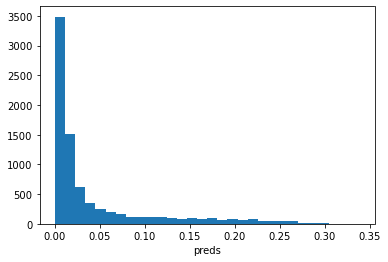

In [516]:
preds.std(dim='split').preds.plot.hist(bins=30)
plt.show()

In [517]:
pred_mean = preds.preds.mean(dim='split')
pred_median = xr.apply_ufunc(np.median, preds.preds,  input_core_dims=[['split']], kwargs={"axis": -1})

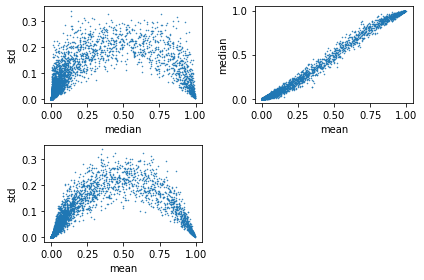

In [521]:
fig, axes = plt.subplots(2,2)

axes[0,0].plot(
    pred_median.values.flatten(), #submission.values.flatten(),
    preds.std(dim='split').preds.values.flatten(), 
    linestyle='',
    marker='.',
    markersize=1
)
axes[0,0].set_xlabel('median')
axes[0,0].set_ylabel('std')


axes[1,0].plot(
    pred_mean.values.flatten(),
    preds.std(dim='split').preds.values.flatten(), 
    linestyle='',
    marker='.',
    markersize=1
)
axes[1,0].set_xlabel('mean')
axes[1,0].set_ylabel('std')

axes[0,1].plot(
    pred_mean.values.flatten(),
    pred_median.values.flatten(), 
    linestyle='',
    marker='.',
    markersize=1
)
axes[0,1].set_xlabel('mean')
axes[0,1].set_ylabel('median')


axes[1,1].axis("off")
plt.tight_layout()
plt.show()

In [522]:
df = pred_mean.to_dataframe().unstack()
df.columns = df.columns.droplevel(None)
df.columns.name=None
df

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0766,0.023003,0.099709,0.014384,0.034203,0.000529,0.007719,0.046424,0.240497,0.067764,0.002598
S0767,0.048898,0.012684,0.007832,0.040340,0.000471,0.006761,0.160677,0.506121,0.021866,0.004743
S0768,0.268161,0.570830,0.008652,0.036245,0.000473,0.003903,0.621436,0.668104,0.009074,0.001918
S0769,0.009392,0.070318,0.047876,0.502814,0.001048,0.525587,0.022254,0.009983,0.790611,0.036303
S0770,0.008252,0.006953,0.019031,0.354514,0.000373,0.988541,0.983521,0.005930,0.008784,0.001320
...,...,...,...,...,...,...,...,...,...,...
S1565,0.059446,0.069613,0.033090,0.056037,0.253291,0.014130,0.095571,0.049752,0.147043,0.020258
S1566,0.046976,0.028989,0.079822,0.024387,0.003999,0.097301,0.067264,0.007667,0.020677,0.019394
S1567,0.006885,0.170661,0.010316,0.005401,0.002293,0.005190,0.154713,0.005473,0.065542,0.005896


In [523]:
df.to_csv('submission.csv')